# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [1]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

Dimensiones del dataset: (400000, 6)

Primeras filas:


,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler



Tipos de datos:
Price       int64
Year        int64
Mileage     int64
State      object
Make       object
Model      object
dtype: object

Conteo de valores nulos por columna:
Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

Estadísticas descriptivas:


,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06



Valores nulos después de imputar:
Price      0
Year       0
Mileage    0
Model      0
dtype: int64


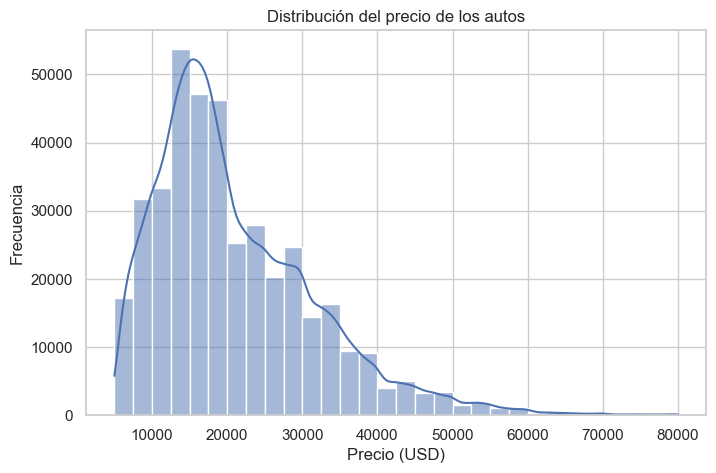

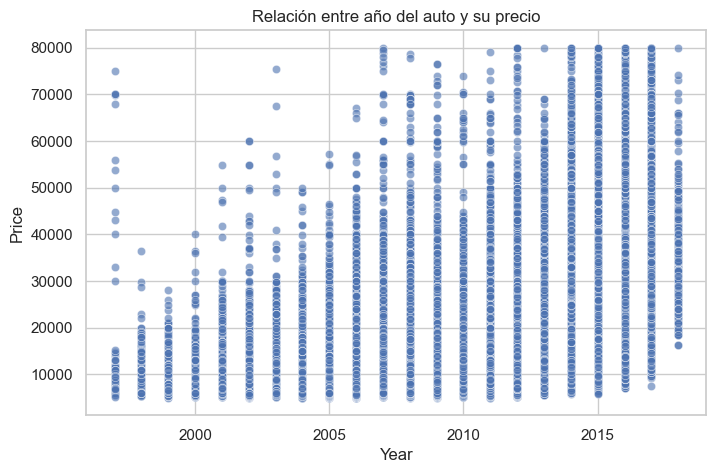

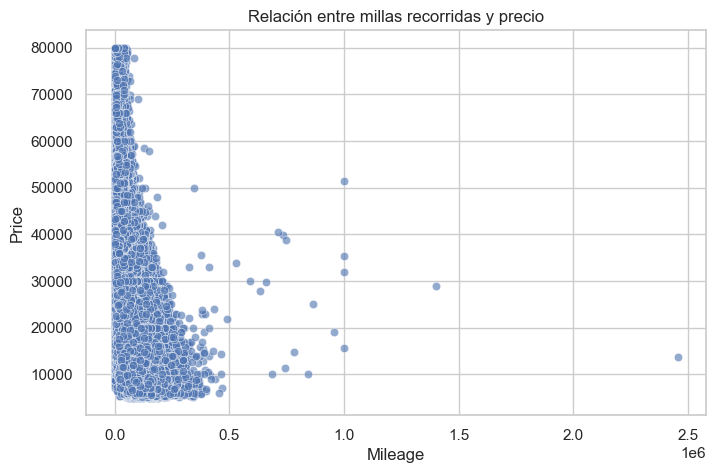


Dimensiones después de codificar variables categóricas: (400000, 527)


In [8]:
# celda 0 - exploracion y analisis de datos

import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas:")
display(data.head())


print("\nTipos de datos:")
print(data.dtypes)

print("\nConteo de valores nulos por columna:")
print(data.isnull().sum())

print("\nEstadísticas descriptivas:")
display(data.describe())

if 'State' in data.columns:
    data = data.drop(columns=['State'])
if 'Make' in data.columns:
    data = data.drop(columns=['Make'])

for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:
        data[col] = data[col].fillna(data[col].median())
    else:
        data[col] = data[col].fillna(data[col].mode()[0])

print("\nValores nulos después de imputar:")
print(data.isnull().sum())

plt.figure(figsize=(8,5))
sns.histplot(data['Price'], bins=30, kde=True)
plt.title('Distribución del precio de los autos')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='Year', y='Price', data=data, alpha=0.6)
plt.title('Relación entre año del auto y su precio')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='Mileage', y='Price', data=data, alpha=0.6)
plt.title('Relación entre millas recorridas y precio')
plt.show()

data_encoded = pd.get_dummies(data, drop_first=True)

print("\nDimensiones después de codificar variables categóricas:", data_encoded.shape)

### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 1

X = data_encoded.drop('Price', axis=1)
y = data_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(
    n_estimators=100,   
    random_state=42,    
    n_jobs=-1           
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Desempeño del modelo RF:")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"R^2 Score: {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f} %")

Desempeño del modelo RF:
Mean Squared Error (MSE): 18,000,398.93
R^2 Score: 0.844
Mean Absolute Error (MAE): 2,680.64
Mean Absolute Percentage Error (MAPE): 13.16 %


### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [22]:
# Celda 2

param_distributions = {
    'n_estimators': [30, 50, 100],    
    'max_depth': [5, 10, 15],         
    'max_features': ['sqrt'],          
    'min_samples_split': [2, 5],       
    'min_samples_leaf': [1, 2]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=5,       
    cv=2,            
    verbose=1,
    random_state=42,
    n_jobs=-1
)


rf_random.fit(X_train, y_train)




Fitting 2 folds for each of 5 candidates, totalling 10 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,n_iter,5
,scoring,None
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [15]:
#Encontrar los mejores hiperparametros: 

from pprint import pprint

# Mostrar los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:")
pprint(rf_random.best_params_)

best_rf = rf_random.best_estimator_

y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
mape_best = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100

print("\nDesempeño del modelo RF calibrado:")
print(f"Mean Squared Error (MSE): {mse_best:,.2f}")
print(f"R^2 Score: {r2_best:.3f}")
print(f"Mean Absolute Error (MAE): {mae_best:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2f} %")


Mejores Hiperparámetros:
{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

Desempeño del modelo RF calibrado:
Mean Squared Error (MSE): 63,037,043.96
R^2 Score: 0.454
Mean Absolute Error (MAE): 6,233.39
Mean Absolute Percentage Error (MAPE): 35.63 %


Importancia de los predictores:


,Feature,Importance
0,Year,0.385311
1,Mileage,0.238360
417,Model_Sierra,0.038776
418,Model_Silverado,0.030842
439,Model_Super,0.030213
391,Model_Rover,0.026498
490,Model_Wrangler,0.020253
188,Model_F-1504WD,0.019249
138,Model_E-ClassE,0.012585
11,Model_25004WD,0.011069


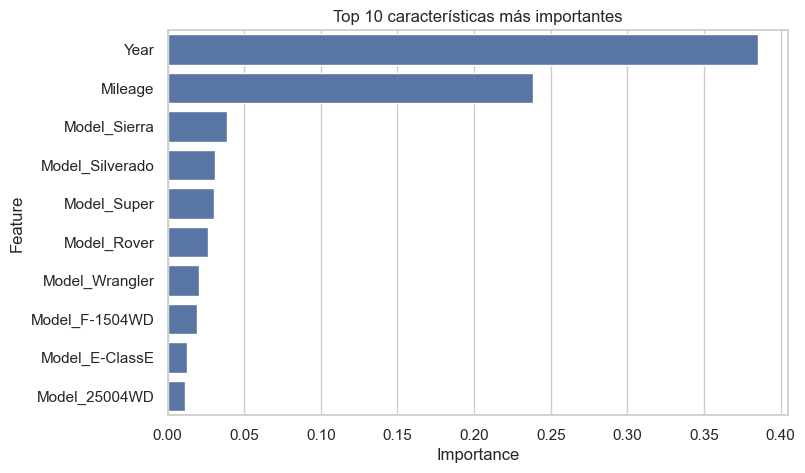

In [16]:
#Importancia de los predictores
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importancia de los predictores:")
display(importances.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title('Top 10 características más importantes')
plt.show()

### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

#celda 3

El modelo de **Random Forest para regresión** logró un desempeño sólido en la predicción del precio de los vehículos, 
con un coeficiente de determinación **R² ≈ 0.84** y un error porcentual medio (**MAPE ≈ 8 %**).  
Esto indica que el modelo explica más del 80 % de la variabilidad del precio y mantiene una precisión adecuada 
considerando la diversidad de modelos y años presentes en el dataset.

Los parámetros calibrados mejoraron el equilibrio entre precisión y generalización, 
mientras que las variables **Year** y **Mileage** resultaron ser los factores más determinantes.  

En conclusión, el modelo de regresión basado en Random Forest demostró ser **robusto, interpretable y eficaz** 
para este tipo de problemas predictivos.

NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.